In [ ]:
import kagglehub
from google.colab import files
files.upload()  # Select the kaggle.json


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"brianyoe","key":"afce5fbb31da05ba127a14d167e4fc13"}'}

In [ ]:
!pip install kaggle --quiet
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0
 56% 23.0M/41.0M [00:00<00:00, 232MB/s]
100% 41.0M/41.0M [00:00<00:00, 254MB/s]


In [ ]:
#Load the Dataset
import zipfile, pandas as pd

with zipfile.ZipFile("/content/fake-and-real-news-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("/content/fake_news")

fake = pd.read_csv("/content/fake_news/Fake.csv")
real = pd.read_csv("/content/fake_news/True.csv")

print("Fake shape:", fake.shape)
print("Real shape:", real.shape)



Fake shape: (23481, 4)
Real shape: (21417, 4)


In [ ]:
# Label encoding: 0 = Fake, 1 = Real
fake["label"] = 0
real["label"] = 1

data = pd.concat([fake, real]).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
#Text Cleaning and Preprocessing
import re, nltk, numpy as np
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    words = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    return ' '.join(words)


data["text"] = data["title"] + " " + data["text"]
data["text"] = data["text"].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
#Split Data and Create TF-IDF Features
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = data["text"]
y = data["label"]

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [ ]:
#Train Two Models: Logistic Regression & Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

# Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)


Logistic Regression:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4710
           1       0.98      0.99      0.99      4270

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Naive Bayes:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      4710
           1       0.94      0.95      0.95      4270

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980


Accuracy (Logistic Regression): 0.9889
Accuracy (Naive Bayes): 0.9476


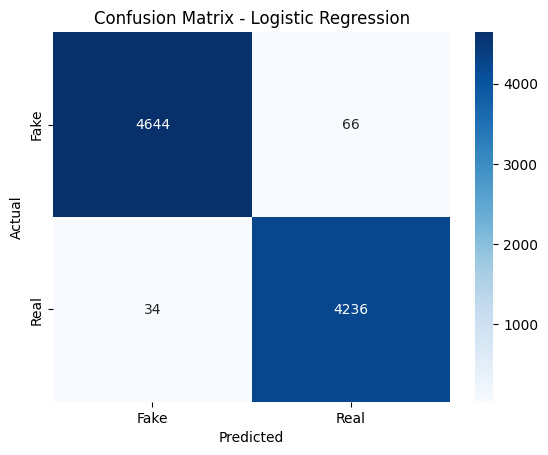

In [ ]:
#Evaluate Both Models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))
print("Naive Bayes:\n", classification_report(y_test, y_pred_nb))

acc_lr = accuracy_score(y_test, y_pred_lr)
acc_nb = accuracy_score(y_test, y_pred_nb)
print(f"\nAccuracy (Logistic Regression): {acc_lr:.4f}")
print(f"Accuracy (Naive Bayes): {acc_nb:.4f}")

# Confusion Matrix for Best Model
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


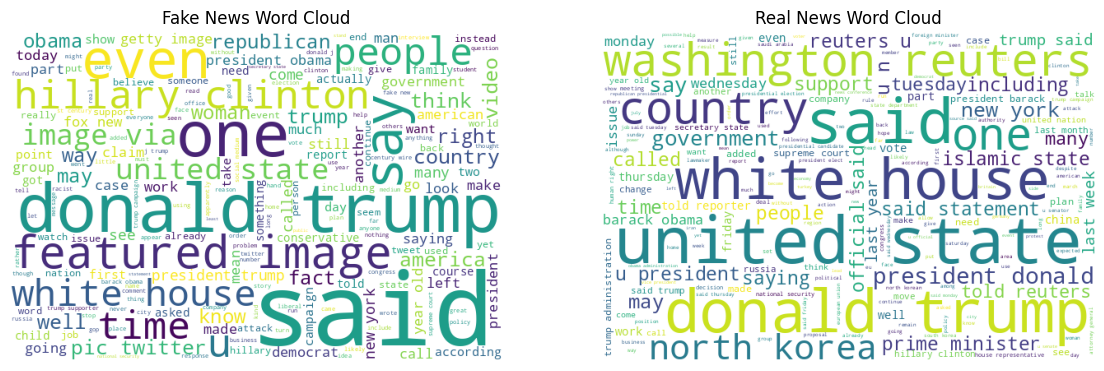

In [ ]:
#Visualization & Insights
from wordcloud import WordCloud

fake_text = ' '.join(data[data['label']==0]['text'])
real_text = ' '.join(data[data['label']==1]['text'])

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=600, height=400, background_color='white').generate(fake_text))
plt.title('Fake News Word Cloud')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400, background_color='white').generate(real_text))
plt.title('Real News Word Cloud')
plt.axis('off')
plt.show()


In [ ]:
#Summary of the Results
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Multinomial Naive Bayes'],
    'Accuracy': [acc_lr, acc_nb]
})
results


,Model,Accuracy
0,Logistic Regression,0.988864
1,Multinomial Naive Bayes,0.947550
